In [1]:
#importing useful packages

%matplotlib inline

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import tpot
from tpot import TPOTClassifier
from tpot import TPOTRegressor
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (50.0, 25.0)

from scipy import stats

plt.rcParams['figure.figsize'] = [50, 25]


In [2]:
#loading the dataframes, removing all rows where no secondary market price was found, either NA or 999999
df_all=pickle.load(open('dfall.p','rb'))
df_low=pickle.load(open('dflow.p','rb'))
df_low=df_low[df_low['secondary']!='NA']
df_all=df_all[df_all['secondary']!='NA']
df_low=df_low[df_low['secondary']!=999999]
df_all=df_all[df_all['secondary']!=999999]
df_low.reset_index(drop=True,inplace=True)
df_all.reset_index(drop=True,inplace=True)



In [3]:
#using this to calculate supplier discounts
def supplier_markup (row):
    #this sets the discount percentage
    percentage=.5
    if row['supplier'][:len('MARVEL COMICS')]=='MARVEL COMICS':
        percentage=.65
    elif row['supplier'][:len('DC COMICS')]=='DC COMICS':
        percentage=.65
    elif row['supplier'][:len('IMAGE COMICS')]=='IMAGE COMICS':
        percentage=.5
    elif row['supplier'][:len('DARK HORSE COMICS')]=='DARK HORSE COMICS':
        percentage=1 
    #this returns the markup,
    return float(row['secondary'])/(float(row['price'])*percentage)

In [4]:
#applying the markup calculation
df_all['markup']=df_all.apply (lambda row: supplier_markup(row), axis=1)
df_low['markup']=df_low.apply (lambda row: supplier_markup(row), axis=1)

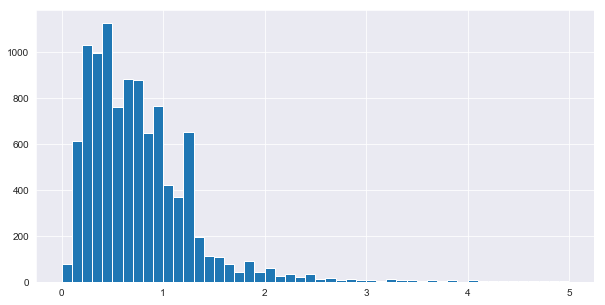

In [5]:
#checking histograms of markup
fig_size=[10,5]
plt.gcf().set_size_inches(*fig_size)
df_all[df_all['markup']<5]['markup'].hist(bins=50)

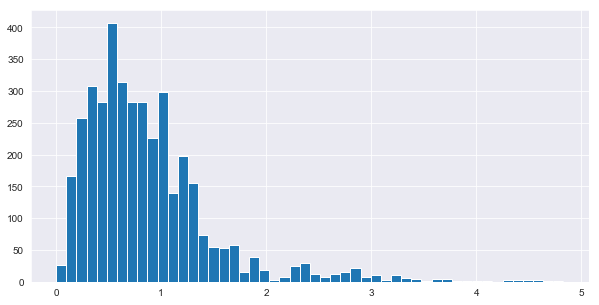

In [6]:
plt.gcf().set_size_inches(*fig_size)
df_low[df_low['markup']<5]['markup'].hist(bins=50)

In [7]:
#log transforming the target variable to normalize the data
df_all['log_markup']=np.log(df_all['markup'])
df_low['log_markup']=np.log(df_low['markup'])

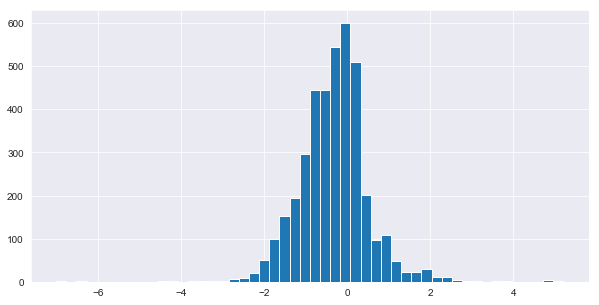

In [8]:
#checking histograms again
plt.gcf().set_size_inches(*fig_size)
df_low['log_markup'].hist(bins=50)

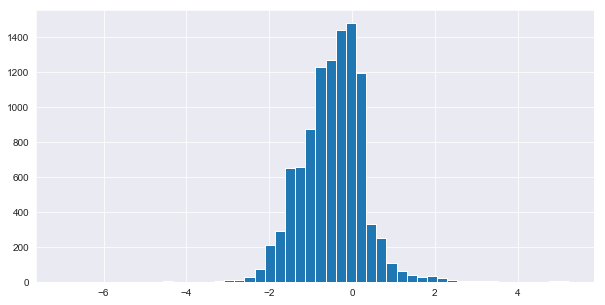

In [9]:
plt.gcf().set_size_inches(*fig_size)
df_all['log_markup'].hist(bins=50)

In [10]:
#setting up a classification target, assigning 1 to any markup of 1 or greater
target_all=[]
for thing in df_all['markup']:
    if thing>1:
        target_all.append(1)
    else:
        target_all.append(0)
target_low=[]

for thing in df_low['markup']:
    if thing>1:
        target_low.append(1)
    else:
        target_low.append(0)

target_all=pd.Series(target_all)
target_low=pd.Series(target_low)
df_all['target']=target_all
df_low['target']=target_low


In [11]:
#removing values that fall outside of a standard deviation threshold
stdvs=4

low_std=df_low['log_markup'].std()
all_std=df_all['log_markup'].std()
low_mean=df_low['log_markup'].mean()
all_mean=df_all['log_markup'].mean()

df_low=df_low[df_low['log_markup']<(low_mean+stdvs*low_std)]
df_low=df_low[df_low['log_markup']>(low_mean-stdvs*low_std)]
df_all=df_all[df_all['log_markup']<(all_mean+stdvs*all_std)]
df_all=df_all[df_all['log_markup']>(all_mean-stdvs*all_std)]


In [12]:
#creating a function that returns whether the string "VOL 1" was in the title
def volume_one (row):
    if re.search('VOL 1',row['title']):
        return 1
    else:
        return 0

In [13]:
#applying the function to both datasets
df_all['vol1']=df_all.apply (lambda row: volume_one(row), axis=1)
df_low['vol1']=df_low.apply (lambda row: volume_one(row), axis=1)

In [14]:
#exporting to csv so I can use tableau for data exploration
df_all.to_csv('df_all.csv')
df_low.to_csv('df_low.csv')

In [15]:
#creating functions for indicating supplier matches
#in retrospect I could have created one function and passed the string to check for as an argument
def find_supplier_marvel (row):
    _marvel=0
        #need to include the [:2] because the data is full of blank spaces
    if row['supplier'][:len('MARVEL COMICS')]=='MARVEL COMICS':
        _marvel=1
    else:
        _marvel=0
    return _marvel

def find_supplier_dc (row):
    _dc=0
    if row['supplier'][:len('DC COMICS')]=='DC COMICS':
        _dc=1
    else:
        _dc=0
    return _dc

def find_supplier_image (row):
    _image=0
    if row['supplier'][:len('IMAGE COMICS')]=='IMAGE COMICS':
        _image=1
    else:
        _image=0
    return _image

def find_supplier_dh (row):
    _dark_horse=0
    if row['supplier'][:len('DARK HORSE COMICS')]=='DARK HORSE COMICS':
        _dark_horse=1
    else:
        _dark_horse=0
    return _dark_horse

def find_supplier_viz (row):
    _viz=0
    if row['supplier'][:len('VIZ LLC')]=='VIZ LLC':
        _viz=1
    else:
        _viz=0
    return _viz

def find_supplier_idw (row):
    _idw=0
    if row['supplier'][:len('IDW PUBLISHING')]=='IDW PUBLISHING':
        _idw=1
    else:
        _idw=0
    return _idw

def find_supplier_daq (row):
    _daq=0
    if row['supplier'][:len('DRAWN & QUARTERLY')]=='DRAWN & QUARTERLY':
        _daq=1
    else:
        _daq=0
    return _daq

def find_supplier_hbg (row):
    _hbg=0
    if row['supplier'][:len('HACHETTE BOOK GROUP')]=='HACHETTE BOOK GROUP':
        _hbg=1
    else:
        _hbg=0
    return _hbg

def find_supplier_oni (row):
    _oni=0
    if row['supplier'][:len('ONI PRESS INC.')]=='ONI PRESS INC.':
        _oni=1
    else:
        _oni=0
    return _oni

def find_supplier_poc (row):
    _poc=0
    if row['supplier'][:len('POCKET BOOKS')]=='POCKET BOOKS':
        _poc=1
    else:
        _poc=0
    return _poc

def find_supplier_ran (row):
    _ran=0
    if row['supplier'][:len('RANDOM HOUSE')]=='RANDOM HOUSE':
        _ran=1
    else:
        _ran=0
    return _ran


In [16]:
#applying the functions
df_all['Marvel']=df_all.apply (lambda row: find_supplier_marvel(row), axis=1)
df_all['DC']=df_all.apply (lambda row: find_supplier_dc(row), axis=1)
df_all['Image']=df_all.apply (lambda row: find_supplier_image(row), axis=1)
df_all['Dark_Horse']=df_all.apply (lambda row: find_supplier_dh(row), axis=1)
df_all['Viz']=df_all.apply (lambda row: find_supplier_viz(row), axis=1)
df_all['IDW']=df_all.apply (lambda row: find_supplier_idw(row), axis=1)
df_all['Drawn&Quarterly']=df_all.apply (lambda row: find_supplier_daq(row), axis=1)
df_all['Hachette']=df_all.apply (lambda row: find_supplier_hbg(row), axis=1)
df_all['Oni']=df_all.apply (lambda row: find_supplier_oni(row), axis=1)
df_all['Pocket']=df_all.apply (lambda row: find_supplier_poc(row), axis=1)
df_all['Random']=df_all.apply (lambda row: find_supplier_ran(row), axis=1)



df_low['Marvel']=df_low.apply (lambda row: find_supplier_marvel(row), axis=1)
df_low['DC']=df_low.apply (lambda row: find_supplier_dc(row), axis=1)
df_low['Image']=df_low.apply (lambda row: find_supplier_image(row), axis=1)
df_low['Dark_Horse']=df_low.apply (lambda row: find_supplier_dh(row), axis=1)
df_low['Viz']=df_low.apply (lambda row: find_supplier_viz(row), axis=1)
df_low['IDW']=df_low.apply (lambda row: find_supplier_idw(row), axis=1)
df_low['Drawn&Quarterly']=df_low.apply (lambda row: find_supplier_daq(row), axis=1)
df_low['Hachette']=df_low.apply (lambda row: find_supplier_hbg(row), axis=1)
df_low['Oni']=df_low.apply (lambda row: find_supplier_oni(row), axis=1)
df_low['Pocket']=df_low.apply (lambda row: find_supplier_poc(row), axis=1)
df_low['Random']=df_low.apply (lambda row: find_supplier_ran(row), axis=1)

In [17]:
#creating a function to calculate volume from height, width, length
def calculate_volume (row):
    _volume=row['height']*row['width']*row['length']
    return _volume

In [18]:
#applying the function
df_all['Volume']=df_all.apply (lambda row: calculate_volume(row), axis=1)
df_low['Volume']=df_low.apply (lambda row: calculate_volume(row), axis=1)

In [19]:
# creating a function to indicate genre matches. Again, could have made one and passed the string as an argument
def find_genre_sh (row):
    _sh=0
    #need to include the [:2] because the data is full of blank spaces
    if row['genre'][:2]=='SH':
        _sh=1
    else:
        _sh=0
    return _sh
def find_genre_ga (row):
    _ga=0
    if row['genre'][:2]=='GA':
        _ga=1
    else:
        _ga=0
    return _ga
def find_genre_fa (row):
    _fa=0
    if row['genre'][:2]=='FA':
        _fa=1
    else:
        _fa=0
    return _fa
def find_genre_ro (row):
    _ro=0
    if row['genre'][:2]=='RO':
        _ro=1
    else:
        _ro=0
    return _ro
def find_genre_rb (row):
    _rb=0
    if row['genre'][:2]=='RB':
        _rb=1
    else:
        _rb=0
    return _rb
def find_genre_ho (row):
    _ho=0
    if row['genre'][:2]=='HO':
        _ho=1
    else:
        _ho=0
    return _ho
def find_genre_ya (row):
    _ya=0
    if row['genre'][:2]=='YA':
        _ya=1
    else:
        _ya=0
    return _ya
def find_genre_ad (row):
    _ad=0
    if row['genre'][:2]=='AD':
        _ad=1
    else:
        _ad=0
    return _ad
def find_genre_xx (row):
    _xx=0
    if row['genre'][:2]=='XX':
        _xx=1
    else:
        _xx=0
    return _xx
def find_genre_mv (row):
    _mv=0
    if row['genre'][:2]=='MV':
        _mv=1
    else:
        _mv=0
    return _mv
def find_genre_lt (row):
    _lt=0
    if row['genre'][:2]=='LT':
        _lt=1
    else:
        _lt=0
    return _lt
def find_genre_cr (row):
    _cr=0
    if row['genre'][:2]=='CR':
        _cr=1
    else:
        _cr=0
    return _cr

In [20]:
#applying the function to both all and low
df_all['Hero']=df_all.apply (lambda row: find_genre_sh(row), axis=1)
df_all['Fantasy']=df_all.apply (lambda row: find_genre_fa(row), axis=1)
df_all['Gaming']=df_all.apply (lambda row: find_genre_ga(row), axis=1)
df_all['Romance']=df_all.apply (lambda row: find_genre_ro(row), axis=1)
df_all['Reality']=df_all.apply (lambda row: find_genre_rb(row), axis=1)
df_all['Horror']=df_all.apply (lambda row: find_genre_ho(row), axis=1)
df_all['Yaoi']=df_all.apply (lambda row: find_genre_ya(row), axis=1)
df_all['Movie']=df_all.apply (lambda row: find_genre_mv(row), axis=1)
df_all['Adult']=df_all.apply (lambda row: find_genre_ad(row), axis=1)
df_all['Literary']=df_all.apply (lambda row: find_genre_lt(row), axis=1)
df_all['Crime']=df_all.apply (lambda row: find_genre_cr(row), axis=1)
df_all['No_Genre']=df_all.apply (lambda row: find_genre_xx(row), axis=1)

df_low['Hero']=df_low.apply (lambda row: find_genre_sh(row), axis=1)
df_low['Fantasy']=df_low.apply (lambda row: find_genre_fa(row), axis=1)
df_low['Gaming']=df_low.apply (lambda row: find_genre_ga(row), axis=1)
df_low['Romance']=df_low.apply (lambda row: find_genre_ro(row), axis=1)
df_low['Reality']=df_low.apply (lambda row: find_genre_rb(row), axis=1)
df_low['Horror']=df_low.apply (lambda row: find_genre_ho(row), axis=1)
df_low['Yaoi']=df_low.apply (lambda row: find_genre_ya(row), axis=1)
df_low['Movie']=df_low.apply (lambda row: find_genre_mv(row), axis=1)
df_low['Adult']=df_low.apply (lambda row: find_genre_ad(row), axis=1)
df_low['Literary']=df_low.apply (lambda row: find_genre_lt(row), axis=1)
df_low['Crime']=df_low.apply (lambda row: find_genre_cr(row), axis=1)
df_low['No_Genre']=df_low.apply (lambda row: find_genre_xx(row), axis=1)

In [21]:
#extracting my target variables
y_all=df_all['log_markup']
y_low=df_low['log_markup']
y_all3=df_all['markup']
y_low3=df_low['markup']
y_all2=df_all['target']
y_low2=df_low['target']
#dropping variables by hand
df_a=df_all.drop(['code','title','net_item','category','upc','off_site','isbn','secondary','inv_date','markup','brand_code','supplier','genre','height','width','length','case_qty','price','msrp','year','markup','target','log_markup','weight'],axis=1)
df_l=df_low.drop(['code','title','net_item','category','upc','low_stock','off_site','isbn','secondary','inv_date','markup','brand_code','supplier','genre','height','width','length','case_qty','price','msrp','year','markup','target','log_markup','weight'],axis=1)


In [22]:
#converting year to an int, scaling it so it starts at zero
df_l['year']=df_low['year'].astype(int)-df_low['year'].astype(int).min()
df_a['year']=df_all['year'].astype(int)-df_all['year'].astype(int).min()
df_a=pd.get_dummies(df_a,drop_first=True)

In [23]:
#creating larger dataframes where only ID features, features with obvious multicolinearity issues, or with no discriminating power were dropped
working_all=df_all.drop(['secondary','code','title','msrp','upc','isbn','supplier','genre','inv_date','category','markup','target','log_markup'],axis=1)
working_all['year']=working_all['year'].astype(int)
working_all_ohe=pd.get_dummies(working_all)

working_low=df_low.drop(['secondary','code','title','msrp','upc','isbn','supplier','genre','inv_date','category','markup','target','log_markup'],axis=1)
working_low['year']=working_low['year'].astype(int)
working_low_ohe=pd.get_dummies(working_low)


In [24]:
#using lasso on the larger dataframe to select a subset of relevant features
X_train, X_test, y_train, y_test = train_test_split(working_all_ohe, y_all, test_size=0.33, random_state=2)

lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso.score(X_test,y_test)

lasso_selection_all=working_all_ohe.iloc[:, pd.Series(lasso.coef_>0).values]

#generating lasso selection of features for low stock
X_train, X_test, y_train, y_test = train_test_split(working_low_ohe, y_low, test_size=0.33, random_state=2)

lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso.score(X_test,y_test)
lasso_selection_low=working_low_ohe.iloc[:, pd.Series(lasso.coef_>0).values]

In [25]:
#a method to check assumptions of linear regression

def check_assumptions(model,X,y):
    
    #getting fitted vals and residuals
    fitted_vals = model.predict(X)
    resids = y-fitted_vals
    
    #setting subplots and plot sizes
    fig, ax = plt.subplots(2,2)
    fig_size=[20,10]
    plt.gcf().set_size_inches(*fig_size)
    
    #performing linearity test
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0][0], line_kws={'color': 'red'})
    ax[0][0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0][0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0][1], line_kws={'color': 'red'})
    ax[0][1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[0][1].set(xlabel='Predicted', ylabel='Residuals')
    
    #homoscedacicity test
    
    #getting standardized residuals
    resids_standardized = []
    std_of_resids=np.std(resids)
    for thing in resids:
        resids_standardized.append(thing/std_of_resids)


    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1][0], line_kws={'color': 'red'})
    ax[1][0].set_title('Scale-Location', fontsize=16)
    ax[1][0].set(xlabel='Fitted Values', ylabel='sqrt(abs(Standardized Residuals))')
    
    #checking for normality of standardized residuals

    stats.probplot(resids_standardized,plot=ax[1][1])
    
    #checking mean of residuals
    print('mean of residuals')
    print(np.mean(y-model.predict(X)))
    

    #checking the variance inflation factors
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(pd.DataFrame({'vif': vif[0:]}, index=X.columns).sort_values(by=['vif'], ascending=False))
    

In [26]:
#set list of dataframes to iterate through
alls=[df_a,lasso_selection_all]
lows=[df_l,lasso_selection_low]

#create a list of regressors to try
regs=[linear_model.Lasso(alpha=0.1),Ridge(alpha=1),SVR(),RandomForestRegressor(max_depth=7,random_state=0),RandomForestRegressor(max_depth=5,random_state=0),KNeighborsRegressor(n_neighbors=2)]

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
0.001614758696815799 +/-0.008895986929915627
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
0.20176093796580993 +/-0.02840971808502703
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0.03389549315948549 +/-0.022635942283510475
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10

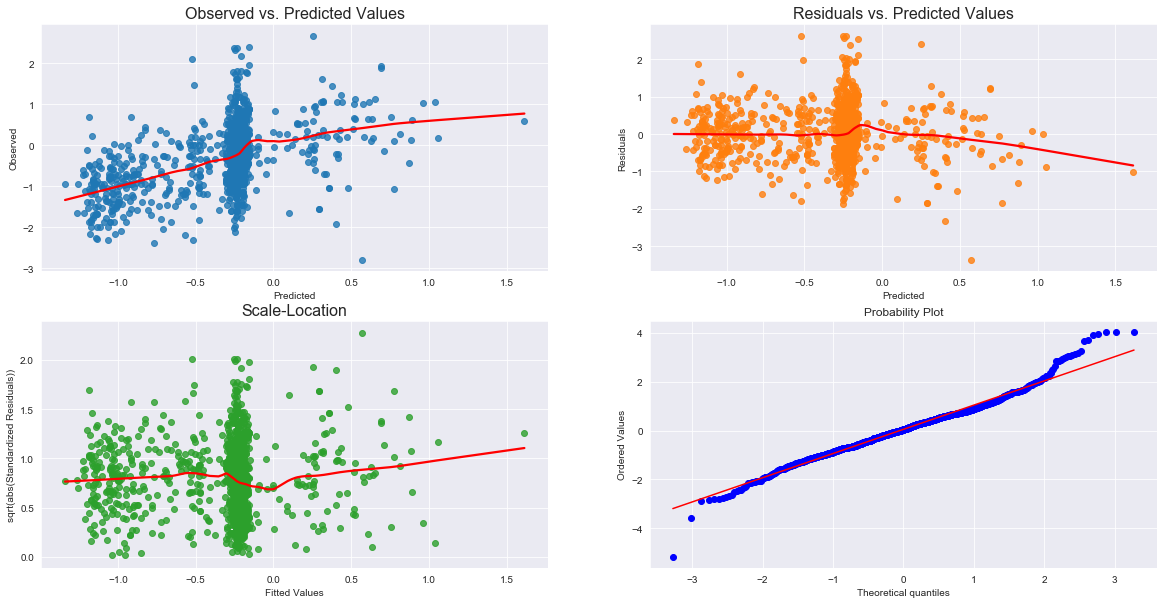

In [27]:
"""This loops through the dataframes and regressors and evaluates their performance"""

#using these to track best results
low_best_r2=0
reg_low_best='none'

#iterate through the dataframes
for idx,df in enumerate(lows):
    #perform train test split
    X_train, X_test, y_train, y_test = train_test_split(df, y_low, test_size=0.33, random_state=2)
    #iterate through regressors
    for reg in regs:
        #print model, and r2 score
        print(reg)
        reg.fit(X_train, y_train)
        #performing 10fold cross validation
        scores=cross_val_score(reg, X_train, y_train, cv=10,scoring='r2')
        print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
        #if its the best score, save it
        if np.mean(scores)>low_best_r2:
            low_best_r2=np.mean(scores)
            reg_low_best=reg
            reg_low_best_df=df
            if idx==0:
                reg_low_best_df_label='cut'
            elif idx==1:
                reg_low_best_df_label='lasso'

#print the best score               
print(reg_low_best)
print(low_best_r2)
print(reg_low_best_df_label)
#check assumptions of linear regression on best score
X_train, X_test, y_train, y_test = train_test_split(reg_low_best_df, y_low, test_size=0.33, random_state=2)
reg_low_best.fit(X_train,y_train)
check_assumptions(reg_low_best,X_test,y_test)

In [28]:
"""This cell uses TPOT, just uncomment it if you want to use it. It takes a while"""
# #use tpot for model grid searching models
# X_train, X_test, y_train, y_test = train_test_split(df_l, y_low, test_size=0.33, random_state=2)
# tpotlr=TPOTRegressor(generations=5,verbosity=2,scoring='r2')
# tpotlr.fit(X_train, y_train)
# print(tpotlr)

# #check assumptions on best model found
# check_assumptions(tpotlr,X_test,y_test)

'This cell uses TPOT, just uncomment it if you want to use it. It takes a while'

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
0.003201326244507541 +/-0.003750744842719884
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
0.20666362055759652 +/-0.020379442873941295
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0.10761491441058388 +/-0.013900997643954244
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1

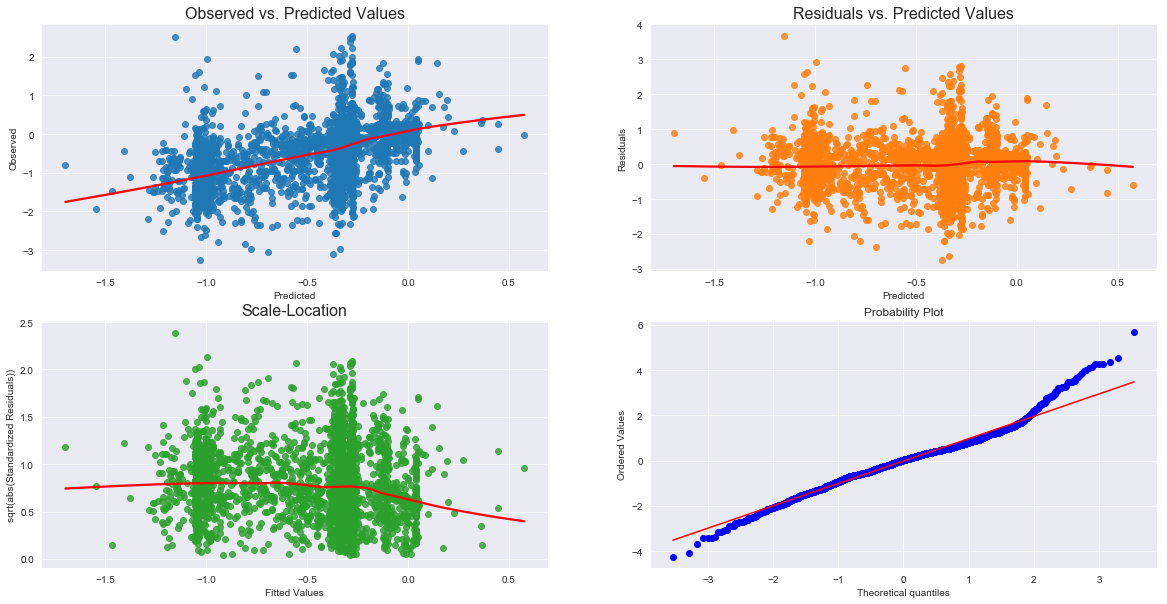

In [29]:
#same as above but for full stock inventory rather than low
all_best_r2=0
reg_all_best='none'

for idx,df in enumerate(alls):
    X_train, X_test, y_train, y_test = train_test_split(df, y_all, test_size=0.33, random_state=2)
    for reg in regs:
        print(reg)
        reg.fit(X_train, y_train)
        scores=cross_val_score(reg, X_train, y_train, cv=10,scoring='r2')
        print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
        if np.mean(scores)>all_best_r2:
            all_best_r2=np.mean(scores)
            reg_all_best=reg
            reg_all_best_df=df
            if idx==0:
                reg_all_best_df_label='cut'
            elif idx==1:
                reg_all_best_df_label='lasso'
    
print(reg_all_best)
print(all_best_r2)
print(reg_all_best_df_label)
X_train, X_test, y_train, y_test = train_test_split(reg_all_best_df, y_all, test_size=0.33, random_state=2)
reg_all_best.fit(X_train,y_train)
check_assumptions(reg_all_best,X_test,y_test)

In [30]:
"""This cell uses TPOT, just uncomment it if you want to use it. It takes a while"""
# #using tpot for grid searching on full inventory
# X_train, X_test, y_train, y_test = train_test_split(df_a, y_all, test_size=0.33, random_state=2)
# tpotar=TPOTRegressor(generations=5,verbosity=2,scoring='r2')
# tpotar.fit(X_train, y_train)
# print(tpotar)

# check_assumptions(tpotar,X_test,y_test)

'This cell uses TPOT, just uncomment it if you want to use it. It takes a while'

In [31]:
"""putting it together"""
#All dataset

'putting it together'

mean of residuals
-0.006983571511799248
                      vif
year             6.424410
Hero             5.864491
Marvel           4.116423
DC               3.109143
Viz              1.973350
low_stock_Y      1.963012
Fantasy          1.438184
IDW              1.339893
Image            1.308115
Horror           1.261127
vol1             1.244739
Dark_Horse       1.238070
Drawn&Quarterly  1.232014
Hachette         1.213138
Reality          1.210388
Volume           1.173353
Romance          1.148319
Random           1.147773
Crime            1.094760
No_Genre         1.090121
Oni              1.074068
Movie            1.065633
Yaoi             1.042416
Pocket           1.035230
Literary         1.029192
Gaming           1.028473
Adult            1.025792
0.2581079452184089 +/-0.020102975799320296
feature importance


[('Volume', 0.243481068225549),
 ('year', 0.15258737065483613),
 ('Hero', 0.1290861232194114),
 ('Dark_Horse', 0.11667953775140212),
 ('Marvel', 0.09060910193612559),
 ('DC', 0.07380955804276794),
 ('Hachette', 0.022115228395120142),
 ('low_stock_Y', 0.021076645883461576),
 ('Viz', 0.020021577394434678),
 ('Random', 0.015417445860514129),
 ('Romance', 0.011336075465089891),
 ('Fantasy', 0.011237927155783162),
 ('Adult', 0.01106335215921499),
 ('vol1', 0.01025882219355795),
 ('Image', 0.009692908078771937),
 ('IDW', 0.0090442739766308),
 ('Reality', 0.00887944833445236),
 ('Horror', 0.007768000180962757),
 ('Crime', 0.0060873001843418624),
 ('Gaming', 0.004993344246478507),
 ('Pocket', 0.0047224971203480666),
 ('Literary', 0.0038093535389722723),
 ('Drawn&Quarterly', 0.0034637879393449424),
 ('No_Genre', 0.0033987084752549346),
 ('Yaoi', 0.0032304315159860987),
 ('Oni', 0.0031850350644843594),
 ('Movie', 0.002945077006702464)]

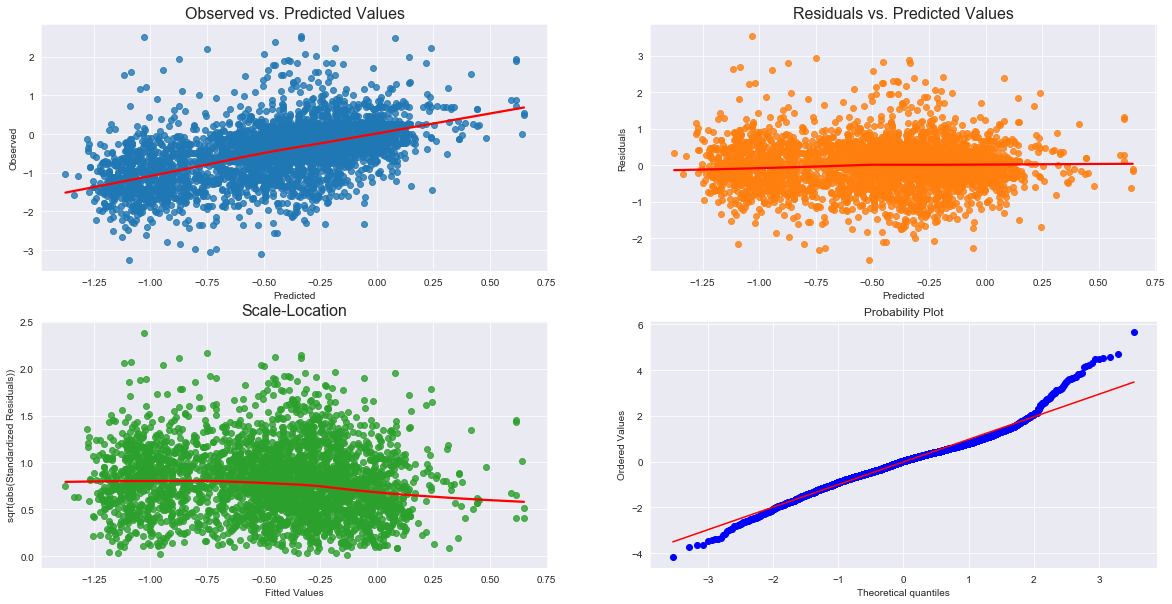

In [32]:
#train the best regressor
reg = RandomForestRegressor(bootstrap=False, max_features=0.1500000002, min_samples_leaf=2, min_samples_split=17, n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(df_a, y_all, test_size=0.33, random_state=2)
reg.fit(X_train,y_train)
#check assumptions and r2 score
check_assumptions(reg,X_test,y_test)
scores=cross_val_score(reg, X_train, y_train, cv=10,scoring='r2')
print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
r2_score(y_test,reg.predict(X_test))
#get feature importances
imp ={}
for name, importance in zip(X_train.columns,reg.feature_importances_):
    #print(name+str(importance))
    imp[name]=importance
print('feature importance')
sorted(imp.items(), key=lambda x: x[1], reverse=True)

In [33]:
# #making predictions and sorting by markup

X_train, X_test, y_train, y_test = train_test_split(df_a, y_all, test_size=0.33, random_state=2)
#predict
y_pred=reg.predict(X_test)
y_true=y_test
#reconvert to markup from ln transformed
y_pred_converted=np.exp(y_pred)
y_true_converted=np.exp(y_true)
#use the full dataset so we can see title
X_train, X_all_results, y_train, y_test = train_test_split(df_all, y_all, test_size=0.33, random_state=2)
#append the calculated fields
X_all_results['y_pred']=y_pred_converted
X_all_results['y_true']=y_true_converted
X_all_results['ln_y_pred']=y_pred
X_all_results['ln_y_true']=y_true
X_all_results.sort_values(by=['y_pred'],ascending=False).head(40)

,code,title,net_item,msrp,category,inv_date,genre,brand_code,price,supplier,...,Yaoi,Movie,Adult,Literary,Crime,No_Genre,y_pred,y_true,ln_y_pred,ln_y_true
3490,APR141356E,CRIMSON SPELL GN VOL 04 (A) (C: 1-0-0) ...,0.0,12.99,3.0,05/15/14,AD,MA,12.99,VIZ LLC,...,0,0,1,0,0,0,1.915451,1.724403,0.649953,0.544881
3377,FEB141434E,CRIMSON SPELL GN VOL 03 (A) (C: 1-0-0) ...,0.0,12.99,3.0,03/21/14,AD,MA,12.99,VIZ LLC,...,0,0,1,0,0,0,1.915451,1.624326,0.649953,0.485093
3303,JAN141325E,HIDE AND SEEK GN VOL 02 (A) (C: 1-0-0) ...,0.0,12.99,3.0,02/13/14,AD,MA,12.99,VIZ LLC,...,0,0,1,0,0,0,1.899733,1.000770,0.641713,0.000770
3405,MAR141235F,MONSTER SOUL GN VOL 01 (C: 1-0-0) ...,0.0,10.99,3.0,05/01/14,RO,MA,10.99,RANDOM HOUSE,...,0,0,0,0,0,0,1.845371,6.618744,0.612680,1.889906
3255,JAN141237F,MY LITTLE MONSTER GN VOL 01 (C: 1-0-0) ...,0.0,10.99,3.0,02/26/14,RO,MA,10.99,RANDOM HOUSE,...,0,0,0,0,0,0,1.845371,6.877161,0.612680,1.928206
3762,AUG141547F,SAY I LOVE YOU GN VOL 04 (C: 1-1-0) ...,0.0,10.99,3.0,09/30/14,RO,MA,10.99,RANDOM HOUSE,...,0,0,0,0,0,0,1.845371,2.409463,0.612680,0.879404
3336,FEB141332F,SAY I LOVE YOU GN VOL 01 (C: 1-1-0) ...,0.0,10.99,3.0,04/15/14,RO,MA,10.99,RANDOM HOUSE,...,0,0,0,0,0,0,1.845371,2.047316,0.612680,0.716530
3460,APR141267F,SAY I LOVE YOU GN VOL 02 (C: 1-1-0) ...,0.0,10.99,3.0,06/02/14,RO,MA,10.99,RANDOM HOUSE,...,0,0,0,0,0,0,1.810392,2.409463,0.593543,0.879404
4583,AUG151590F,KISS HIM NOT ME GN VOL 01 ...,0.0,10.99,3.0,10/01/15,RO,MA,10.99,RANDOM HOUSE,...,0,0,0,0,0,0,1.617067,0.915378,0.480614,-0.088419
2378,AUG121128E,TEENS AT PLAY GN FOREVER YOUNG (A) (C: 1-0-0) ...,0.0,9.99,3.0,10/03/12,AD,XX,9.99,EROS COMIX,...,0,0,1,0,0,0,1.572655,1.261261,0.452765,0.232112


In [34]:
#a function to convert markup to profit
def calculate_profit(row):
    percentage=.5
    if row['supplier'][:len('MARVEL COMICS')]=='MARVEL COMICS':
        percentage=.65
    elif row['supplier'][:len('DC COMICS')]=='DC COMICS':
        percentage=.65
    elif row['supplier'][:len('IMAGE COMICS')]=='IMAGE COMICS':
        percentage=.5
    elif row['supplier'][:len('DARK HORSE COMICS')]=='DARK HORSE COMICS':
        percentage=1 
    cost=row['price']*percentage
    sale_price=row['y_pred']*cost
    profit=sale_price-cost
    return profit
def calculate_actual_profit(row):
    percentage=.5
    if row['supplier'][:len('MARVEL COMICS')]=='MARVEL COMICS':
        percentage=.65
    elif row['supplier'][:len('DC COMICS')]=='DC COMICS':
        percentage=.65
    elif row['supplier'][:len('IMAGE COMICS')]=='IMAGE COMICS':
        percentage=.5
    elif row['supplier'][:len('DARK HORSE COMICS')]=='DARK HORSE COMICS':
        percentage=1 
    cost=row['price']*percentage
    sale_price=row['y_true']*cost
    profit=sale_price-cost
    return profit

In [35]:
#apply the function and sort by predicted profit
X_all_results['predicted_profit']=X_all_results.apply (lambda row: calculate_profit(row), axis=1)
X_all_results['actual_profit']=X_all_results.apply (lambda row: calculate_actual_profit(row), axis=1)

X_all_results.sort_values(by=['predicted_profit'],ascending=False).head(40)


,code,title,net_item,msrp,category,inv_date,genre,brand_code,price,supplier,...,Adult,Literary,Crime,No_Genre,y_pred,y_true,ln_y_pred,ln_y_true,predicted_profit,actual_profit
5727,AUG160477E,TOM TOMORROW 25 YEARS OF TOMORROW HC ...,0.0,125.00,3.0,05/08/17,RB,ID,125.00,IDW PUBLISHING,...,0,0,0,0,1.246057,0.679840,0.219984,-0.385898,15.378562,-20.010
8412,SEP181789E,PEANUTS EVERY SUNDAY HC BOX SET 1970 (C: 0-1-2...,0.0,85.00,3.0,12/03/18,HU,XX,85.00,FANTAGRAPHICS BOOKS,...,0,0,0,0,1.338900,2.000000,0.291848,0.693147,14.403235,42.500
8798,SEP182260F,BATTLE ANGEL ALITA COMPLETE SERIES BOX SET (C:...,0.0,179.94,3.0,12/07/18,SF,MA,179.94,RANDOM HOUSE,...,0,0,0,0,1.130627,1.081472,0.122773,0.078323,11.752556,7.330
3919,JUL148183J,LITTLE NEMO DREAM ANOTHER DREAM HC ...,1.0,0.00,3.0,11/13/14,FA,XX,85.00,LOCUST MOON PRESS,...,0,0,0,0,1.247586,2.823529,0.221210,1.037988,10.522389,77.500
1843,JUL111089E,GAHAN WILSON 50 YEARS PLAYBOY CARTOONS HC (NEW...,0.0,75.00,3.0,09/07/11,HU,XX,75.00,FANTAGRAPHICS BOOKS,...,0,0,0,0,1.240103,6.266667,0.215194,1.835245,9.003850,197.500
2084,MAR120398E,COMPLETE CHESTER GOULD DICK TRACY HC VOL 13 ...,0.0,39.99,3.0,05/01/12,CR,ID,39.99,IDW PUBLISHING,...,0,0,1,0,1.431684,1.400350,0.358852,0.336722,8.631526,8.005
3907,OCT141521F,EROS GONE WILD HC NEW PTG (A) (C: 1-0-1) ...,0.0,44.95,3.0,11/19/14,AD,XX,44.95,HUMANOIDS INC,...,1,0,0,0,1.370312,3.310790,0.315038,1.197187,8.322757,51.935
4001,JAN150553E,COMPLETE CHESTER GOULD DICK TRACY HC VOL 18 ...,0.0,39.99,3.0,04/17/15,CR,ID,39.99,IDW PUBLISHING,...,0,0,1,0,1.409999,1.149787,0.343589,0.139577,8.197921,2.995
3490,APR141356E,CRIMSON SPELL GN VOL 04 (A) (C: 1-0-0) ...,0.0,12.99,3.0,05/15/14,AD,MA,12.99,VIZ LLC,...,1,0,0,0,1.915451,1.724403,0.649953,0.544881,5.945851,4.705
3377,FEB141434E,CRIMSON SPELL GN VOL 03 (A) (C: 1-0-0) ...,0.0,12.99,3.0,03/21/14,AD,MA,12.99,VIZ LLC,...,1,0,0,0,1.915451,1.624326,0.649953,0.485093,5.945851,4.055


In [36]:
#cutting based on a markup threshold of 1
X_all_results_cut2=X_all_results[X_all_results['y_pred']>1.0]

#calculating the effect
print('mean profit in full dataset')
print(np.mean(X_all_results['actual_profit']))
print('mean profit with regression cuts')
print(np.mean(X_all_results_cut2['actual_profit']))
print('no of records in full dataset')
print(len(X_all_results['actual_profit']))
print('no of positive markups in full dataset')
print(np.sum(X_all_results['target']))
print('ratio of winners in full dataset')
print(np.sum(X_all_results['target'])/len(X_all_results['actual_profit']))
print('no of records with regression cuts')
print(len(X_all_results_cut2['actual_profit']))
print('no of positive markups with regression cuts')
print(np.sum(X_all_results_cut2['target']))
print('ratio of winners in with regression cuts')
print(np.sum(X_all_results_cut2['target'])/len(X_all_results_cut2['actual_profit']))



mean profit in full dataset
-2.6902673325499364
mean profit with regression cuts
3.2810227272727297
no of records in full dataset
3404
no of positive markups in full dataset
846
ratio of winners in full dataset
0.24853113983548766
no of records with regression cuts
308
no of positive markups with regression cuts
193
ratio of winners in with regression cuts
0.6266233766233766


In [37]:
#checking different threshold levels
thresholds=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5]
#use these to store relevant info
num_pos=[]
pct=[]
avg_profit=[]

#extract #positive, %positive, and avrage profit
for thresh in thresholds:
    X_all_results_cut2=X_all_results[X_all_results['y_pred']>thresh]
    pct.append(np.sum(X_all_results_cut2['target'])/len(X_all_results_cut2['actual_profit']))
    num_pos.append(np.sum(X_all_results_cut2['target']))
    avg_profit.append(np.mean(X_all_results_cut2['actual_profit']))

In [38]:
#turn it into a dataframe and save as a csv for tableau
results_df=pd.DataFrame()
results_df['threshold']=thresholds
results_df['positives']=num_pos
results_df['percent_positive']=pct
results_df['average_profit']=avg_profit
results_df.to_csv('results.csv')

In [39]:
predictions_df=pd.DataFrame()
predictions_df['y_pred']=X_all_results['y_pred']
predictions_df['y_true']=X_all_results['y_true']
predictions_df['actual_profit']=X_all_results.apply (lambda row: calculate_actual_profit(row), axis=1)
predictions_df.to_csv('predictions.csv')
predictions_df

,y_pred,y_true,actual_profit
189,0.396919,0.192404,-10.4935
2571,0.355841,1.029565,0.3265
303,0.715808,0.896321,-0.7750
181,0.435251,0.256581,-7.2435
128,0.678824,4.797990,18.8950
...,...,...,...
6309,0.910274,1.299299,1.4950
7792,1.058818,0.844615,-1.0100
5021,0.323049,0.129268,-19.8035
9847,0.652120,0.138462,-28.0000


In [40]:
"""LOW
Didn't wind up using this"""

"LOW\nDidn't wind up using this"

In [41]:
#Checking low, didn't wind up using this
# reg = RandomForestRegressor(bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=2, min_samples_split=17, n_estimators=100)
# X_train, X_test, y_train, y_test = train_test_split(df_l, y_low, test_size=0.33, random_state=2)
# reg.fit(X_train,y_train)
# check_assumptions(reg,X_test,y_test)
# scores=cross_val_score(reg, X_train, y_train, cv=10,scoring='r2')
# print(str(np.mean(scores))+' +/-' +str(np.std(scores)))


In [42]:
# #making predictions and sorting by markup

# X_train, X_test, y_train, y_test = train_test_split(df_l, y_low, test_size=0.33, random_state=2)
# y_pred=reg.predict(X_test)
# y_true=y_test
# y_pred_converted=np.exp(y_pred)
# y_true_converted=np.exp(y_true)
# X_train, X_low_results, y_train, y_test = train_test_split(df_low, y_low, test_size=0.33, random_state=2)
# X_low_results['y_pred']=y_pred_converted
# X_low_results['y_true']=y_true_converted
# X_low_results['ln_y_pred']=y_pred
# X_low_results['ln_y_true']=y_true
# X_low_results.sort_values(by=['y_pred'],ascending=False).head(40)

In [43]:
# #training the classifier

# # pipeline= make_pipeline(PolynomialFeatures(),MaxAbsScaler(),MultinomialNB())
# # pipeline=make_pipeline(StandardScaler(),RandomForestClassifier())
# pipeline=make_pipeline(StandardScaler(),MLPClassifier((20,20)))

# X_train, X_test, y_train, y_test = train_test_split(df_l, y_low2, test_size=0.33, random_state=2)
# pipeline.fit(X_train,y_train)
# scores=cross_val_score(pipeline, X_train, y_train, cv=10,scoring='f1')
# print('f1')
# print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
# scores=cross_val_score(pipeline, X_train, y_train, cv=10,scoring='roc_auc')
# print('roc_auc')
# print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
# scores=cross_val_score(pipeline, X_train, y_train, cv=10,scoring='precision')
# print('precision')
# print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
# print(confusion_matrix(y_test,pipeline.predict(X_test)))

# target=pipeline.predict(X_test)
# X_low_results['target_pred']=target
# X_low_results['target_true']=y_test


In [44]:
# X_low_results['predicted_profit']=X_low_results.apply (lambda row: calculate_profit(row), axis=1)
# X_low_results['actual_profit']=X_low_results.apply (lambda row: calculate_actual_profit(row), axis=1)
# X_low_results.sort_values(by=['predicted_profit'],ascending=False).head(40)


In [45]:
# #calculating the MSE
# X_low_results['Squared_Error']=X_low_results.apply (lambda row: calculate_SE(row), axis=1)
# MSE1_low=np.mean(X_low_results['Squared_Error'])
# MSE1_low
# r2_normal_low=r2_score(X_low_results['ln_y_true'],X_low_results['ln_y_pred'])

In [46]:
# #filtering by classifier predictions and recalculating MSE
# X_low_results_cut=X_low_results[X_low_results['target_pred']==1]
# X_low_results_cut=X_low_results_cut[X_low_results_cut['y_pred']>1]
# MSE2_low=np.mean(X_low_results_cut['Squared_Error'])
# r2_class_low=r2_score(X_low_results_cut['ln_y_true'],X_low_results_cut['ln_y_pred'])
# print("MSE")
# print(MSE1_low)
# print("MSE with classification")
# print(MSE2_low)
# print("r2")
# print(r2_normal_low)
# print("r2 with classification")
# print(r2_class_low)
# print('mean profit')
# print(np.mean(X_low_results_cut['actual_profit']))
# print('mean profit without cutting')
# print(np.mean(X_low_results['actual_profit']))
# X_low_results_cut.sort_values(by=['predicted_profit'],ascending=False).head(40)


In [47]:
"""This code is for testing and training classifiers"""

'This code is for testing and training classifiers'

In [48]:
# #creating a list of classifiers to try
# clfs=[GaussianNB(),MLPClassifier((20,20)),SVC(),LinearSVC(),RandomForestClassifier(),DecisionTreeClassifier(),KNeighborsClassifier(), MultinomialNB(), LogisticRegression()]

In [49]:

# #using these to store results
# recall=[]
# recallpm=[]
# roc_auc=[]
# roc_aucpm=[]
# confusion=[]
# which_df=[]
# classifier=[]
# f1=[]
# f1pm=[]
# precision=[]
# precisionpm=[]

# #iterating through each classifier in low stock
# for idx,df in enumerate(lows):
#     #perform train test split
#     X_train, X_test, y_train, y_test = train_test_split(df, y_low2, test_size=0.33, random_state=2)
#     #iterate through classifirs
#     for clf in clfs:
#         #get f1, precision, recall, roc_auc, and confusion matrix from 10fold cross val. Store scores
#         classifier.append(clf)
#         clf.fit(X_train, y_train)
#         scores=cross_val_score(clf, X_train, y_train, cv=10,scoring='f1')
#         f1.append(np.mean(scores))
#         f1pm.append(np.std(scores))
#         scores=cross_val_score(clf, X_train, y_train, cv=10,scoring='precision')
#         precision.append(np.mean(scores))
#         precisionpm.append(np.std(scores))
#         scores=cross_val_score(clf, X_train, y_train, cv=10,scoring='recall')
#         recall.append(np.mean(scores))
#         recallpm.append(np.std(scores))
#         scores=cross_val_score(clf, X_train, y_train, cv=10,scoring='roc_auc')
#         roc_auc.append(np.mean(scores))
#         roc_aucpm.append(np.std(scores))
#         confusion.append(confusion_matrix(y_test,clf.predict(X_test)))
#         #record which dataframe it comes from
#         if idx==0:
#             which_df.append('cut')
#         elif idx==1:
#             which_df.append('lasso selected')


In [50]:
# #use tpot for model tuning grid search
# X_train, X_test, y_train, y_test = train_test_split(df_l, y_low2, test_size=0.33, random_state=2)    

# tpotlc=TPOTClassifier(generations=3,verbosity=2,scoring='f1')
# tpotlc.fit(X_train, y_train)
# #record same scores
# f1.append(f1_score(y_test,tpotlc.predict(X_test),average='binary'))
# confusion.append(confusion_matrix(y_test,tpotlc.predict(X_test)))
# recall.append(recall_score(y_test,tpotlc.predict(X_test)))
# precision.append(precision_score(y_test,tpotlc.predict(X_test)))
# roc_auc.append(roc_auc_score(y_test,tpotlc.predict(X_test)))
# which_df.append('cut')
# #can't get std dev of cross val, append zero instead
# f1pm.append(0)
# recallpm.append(0)
# precisionpm.append(0)
# roc_aucpm.append(0)
# classifier.append(tpotlc)



In [51]:
# #create the dataframe of results
# df_low_class=pd.DataFrame()
# df_low_class['classifier']=classifier
# df_low_class['which_df']=which_df
# df_low_class['f1']=f1
# df_low_class['f1_+/-']=f1pm
# df_low_class['precision']=precision
# df_low_class['precision_+/-']=precisionpm
# df_low_class['recall']=recall
# df_low_class['recall_+/-']=recallpm
# df_low_class['roc_auc']=roc_auc
# df_low_class['roc_auc_+/-']=roc_aucpm
# df_low_class['confusion']=confusion



In [52]:
# #display the dataframe sorted by f1
# df_low_class.sort_values(by=['f1'],ascending=False)

In [53]:
# #test case, figuring out orientation of sklearn confusion matrix
# X_train, X_test, y_train, y_test = train_test_split(df_l, y_low2, test_size=0.33, random_state=2)    

# y_tpred=tpotlc.predict(X_test)

In [54]:
# pd.Series(y_tpred).value_counts()

In [55]:
# pd.Series(y_test).value_counts()

In [56]:
#here is the orientation
"""
True neg      False Pos
False neg     True positive

"""

'\nTrue neg      False Pos\nFalse neg     True positive\n\n'

In [57]:
# #now for alls

# #using these to store results
# recall=[]
# recallpm=[]
# roc_auc=[]
# roc_aucpm=[]
# confusion=[]
# which_df=[]
# classifier=[]
# f1=[]
# f1pm=[]
# precision=[]
# precisionpm=[]

# #iterating through each classifier in full stock
# for idx,df in enumerate(alls):
#     #perform train test split
#     X_train, X_test, y_train, y_test = train_test_split(df, y_all2, test_size=0.33, random_state=2)
#     #iterate through classifirs
#     for clf in clfs:
#         #get f1, precision, recall, roc_auc, and confusion matrix from 10fold cross val. Store scores
#         classifier.append(clf)
#         clf.fit(X_train, y_train)
#         scores=cross_val_score(clf, X_train, y_train, cv=10,scoring='f1')
#         f1.append(np.mean(scores))
#         f1pm.append(np.std(scores))
#         scores=cross_val_score(clf, X_train, y_train, cv=10,scoring='precision')
#         precision.append(np.mean(scores))
#         precisionpm.append(np.std(scores))
#         scores=cross_val_score(clf, X_train, y_train, cv=10,scoring='recall')
#         recall.append(np.mean(scores))
#         recallpm.append(np.std(scores))
#         scores=cross_val_score(clf, X_train, y_train, cv=10,scoring='roc_auc')
#         roc_auc.append(np.mean(scores))
#         roc_aucpm.append(np.std(scores))
#         confusion.append(confusion_matrix(y_test,clf.predict(X_test)))
#         #record which dataframe it comes from
#         if idx==0:
#             which_df.append('cut')
#         elif idx==1:
#             which_df.append('lasso selected')


In [58]:
# #use tpot for model tuning grid search
# X_train, X_test, y_train, y_test = train_test_split(df_a, y_all2, test_size=0.33, random_state=2)    

# tpotac=TPOTClassifier(generations=3,verbosity=2,scoring='f1')
# tpotac.fit(X_train, y_train)
# #record same scores
# f1.append(f1_score(y_test,tpotac.predict(X_test),average='binary'))
# confusion.append(confusion_matrix(y_test,tpotac.predict(X_test)))
# recall.append(recall_score(y_test,tpotac.predict(X_test)))
# precision.append(precision_score(y_test,tpotac.predict(X_test)))
# roc_auc.append(roc_auc_score(y_test,tpotac.predict(X_test)))
# which_df.append('cut')
# #can't get std dev of cross val, append zero instead
# f1pm.append(0)
# recallpm.append(0)
# precisionpm.append(0)
# roc_aucpm.append(0)
# classifier.append(tpotac)

In [59]:
# #create the dataframe of results
# df_all_class=pd.DataFrame()
# df_all_class['classifier']=classifier
# df_all_class['which_df']=which_df
# df_all_class['f1']=f1
# df_all_class['f1_+/-']=f1pm
# df_all_class['precision']=precision
# df_all_class['precision_+/-']=precisionpm
# df_all_class['recall']=recall
# df_all_class['recall_+/-']=recallpm
# df_all_class['roc_auc']=roc_auc
# df_all_class['roc_auc_+/-']=roc_aucpm
# df_all_class['confusion']=confusion
# df_all_class.sort_values(by=['precision'],ascending=False)


In [60]:
"""This was to demonstrate multicolinearity issues with a larger set of features"""

'This was to demonstrate multicolinearity issues with a larger set of features'

In [61]:
# #looking at a larger subset of features to show multicolinearity issues
# df = working_low_ohe

# low_best_r2=0
# reg_low_best='none'


# X_train, X_test, y_train, y_test = train_test_split(df, y_low, test_size=0.33, random_state=2)
# for reg in regs:
#     print(reg)
#     reg.fit(X_train, y_train)
#     scores=cross_val_score(reg, X_train, y_train, cv=10,scoring='r2')
#     print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
#     if np.mean(scores)>low_best_r2:
#         low_best_r2=np.mean(scores)
#         reg_low_best=reg
#         reg_low_best_df=df
        
# print(reg_low_best)
# print(low_best_r2)
# X_train, X_test, y_train, y_test = train_test_split(reg_low_best_df, y_low, test_size=0.33, random_state=2)
# reg_low_best.fit(X_train,y_train)
# check_assumptions(reg_low_best,X_test,y_test)

In [62]:
"""Using Markup for Regression Instead of Log_Markup"""

'Using Markup for Regression Instead of Log_Markup'

In [63]:
# #same as the regression loop above, but with markup as a target instead of log_markup
# low_best_r2=0
# reg_low_best='none'

# for idx,df in enumerate(lows):
#     X_train, X_test, y_train, y_test = train_test_split(df, y_low3, test_size=0.33, random_state=2)
#     for reg in regs:
#         print(reg)
#         reg.fit(X_train, y_train)
#         scores=cross_val_score(reg, X_train, y_train, cv=10,scoring='r2')
#         print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
#         if np.mean(scores)>low_best_r2:
#             low_best_r2=np.mean(scores)
#             reg_low_best=reg
#             reg_low_best_df=df
#             if idx==0:
#                 reg_low_best_df_label='working'
#             elif idx==1:
#                 reg_low_best_df_label='cut'
#             elif idx==2:
#                 reg_low_best_df_label='lasso'
    
# print(reg_low_best)
# print(low_best_r2)
# print(reg_low_best_df_label)
# X_train, X_test, y_train, y_test = train_test_split(reg_low_best_df, y_low3, test_size=0.33, random_state=2)
# reg_low_best.fit(X_train,y_train)
# check_assumptions(reg_low_best,X_test,y_test)

In [64]:
# X_train, X_test, y_train, y_test = train_test_split(df_l, y_low3, test_size=0.33, random_state=2)
# tpotlr=TPOTRegressor(generations=5,verbosity=2,scoring='r2')
# tpotlr.fit(X_train, y_train)
# print(tpotlr)

# check_assumptions(tpotlr,X_test,y_test)

In [65]:
# #doing same for alls rather than lows
# all_best_r2=0
# reg_all_best='none'

# for idx,df in enumerate(alls):
#     X_train, X_test, y_train, y_test = train_test_split(df, y_all3, test_size=0.33, random_state=2)
#     for reg in regs:
#         print(reg)
#         reg.fit(X_train, y_train)
#         scores=cross_val_score(reg, X_train, y_train, cv=10,scoring='r2')
#         print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
#         if np.mean(scores)>all_best_r2:
#             all_best_r2=np.mean(scores)
#             reg_all_best=reg
#             reg_all_best_df=df
#             if idx==0:
#                 reg_all_best_df_label='working'
#             elif idx==1:
#                 reg_all_best_df_label='cut'
#             elif idx==2:
#                 reg_all_best_df_label='lasso'
    
# print(reg_all_best)
# print(all_best_r2)
# print(reg_all_best_df_label)
# X_train, X_test, y_train, y_test = train_test_split(reg_all_best_df, y_all3, test_size=0.33, random_state=2)
# reg_all_best.fit(X_train,y_train)
# check_assumptions(reg_low_best,X_test,y_test)

In [66]:
# X_train, X_test, y_train, y_test = train_test_split(df_a, y_all3, test_size=0.33, random_state=2)
# tpotar=TPOTRegressor(generations=5,verbosity=2,scoring='r2')
# tpotar.fit(X_train, y_train)
# print(tpotar)

# check_assumptions(tpotar,X_test,y_test)

In [67]:
"""When i was going to include a classifier as well"""

'When i was going to include a classifier as well'

In [68]:
# #training the classifier

# pipeline=make_pipeline(StandardScaler(),MLPClassifier((20,20)))

# X_train, X_test, y_train, y_test = train_test_split(df_a, y_all2, test_size=0.33, random_state=2)
# pipeline.fit(X_train,y_train)
# #checking the scores
# scores=cross_val_score(pipeline, X_train, y_train, cv=10,scoring='f1')
# print('f1')
# print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
# scores=cross_val_score(pipeline, X_train, y_train, cv=10,scoring='roc_auc')
# print('roc_auc')
# print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
# scores=cross_val_score(pipeline, X_train, y_train, cv=10,scoring='precision')
# print('precision')
# print(str(np.mean(scores))+' +/-' +str(np.std(scores)))
# print(confusion_matrix(y_test,pipeline.predict(X_test)))

# #adding the predictions to the dataframe
# target=pipeline.predict(X_test)
# X_all_results['target_pred']=target
# X_all_results['target_true']=y_test
